# How to use transfer learning and fine-tuning in Keras and Tensorflow to build an image recognition system and classify (almost) any object
Tutorial: https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2
Code: https://github.com/DeepLearningSandbox/DeepLearningSandbox/blob/master/transfer_learning/fine

In [1]:
import numpy as np
import os, random
from tqdm import tqdm

In [2]:
# Split images using tutorial recommended structure
if not os.path.isdir(os.path.join(os.getcwd(), 'train_dir')):
    os.makedirs(os.path.join(os.getcwd(), 'train_dir', 'cat'), exist_ok=True)
    os.makedirs(os.path.join(os.getcwd(), 'train_dir', 'dog'), exist_ok=True)
    os.makedirs(os.path.join(os.getcwd(), 'val_dir', 'cat'), exist_ok=True)
    os.makedirs(os.path.join(os.getcwd(), 'val_dir', 'dog'), exist_ok=True)

    for _ in tqdm(os.listdir("train")):
        random_filename = random.choice(os.listdir("train"))
        random_filename_full = os.path.join(os.getcwd(), 'train', random_filename)
        class_str = random_filename.split('.')[0]
        dataset = np.random.choice(['train', 'val'], p=[0.9, 0.1])
        destination_filename_full = os.path.join(os.getcwd(), dataset + '_dir', class_str, random_filename)    
        os.rename(random_filename_full, destination_filename_full)

In [3]:
import sys
import glob
import argparse
import matplotlib.pyplot as plt

from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

Using TensorFlow backend.


In [4]:
batch_size = 32
train_dir = os.path.join(os.getcwd(), 'train_dir')
val_dir = os.path.join(os.getcwd(), 'val_dir')

train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
)
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=batch_size,
)

Found 22473 images belonging to 2 classes.
Found 2527 images belonging to 2 classes.


In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
predictions = Dense(2, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
# Transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Training
nb_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)]) - 1
nb_val_samples = sum([len(files) for r, d, files in os.walk(val_dir)]) - 1

history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=nb_train_samples//batch_size, 
    epochs=3, 
    verbose=1, 
    validation_data=validation_generator, 
    validation_steps=nb_val_samples//batch_size, 
    class_weight='auto',
    workers=16
)

Epoch 1/3
702/702 [==============================] - 288s - loss: 0.3238 - acc: 0.9100 - val_loss: 0.0939 - val_acc: 0.9559
Epoch 2/3
702/702 [==============================] - 284s - loss: 0.1520 - acc: 0.9418 - val_loss: 0.0772 - val_acc: 0.9695
Epoch 3/3
702/702 [==============================] - 284s - loss: 0.1355 - acc: 0.9503 - val_loss: 0.1113 - val_acc: 0.9595


In [9]:
# Fine tuning
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history_ft = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    epochs=3,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=nb_val_samples//batch_size,
    class_weight='auto',
    workers=16
)

Epoch 1/3
702/702 [==============================] - 417s - loss: 0.0833 - acc: 0.9670 - val_loss: 0.0539 - val_acc: 0.9808
Epoch 2/3
702/702 [==============================] - 414s - loss: 0.0653 - acc: 0.9731 - val_loss: 0.0579 - val_acc: 0.9796
Epoch 3/3
702/702 [==============================] - 414s - loss: 0.0577 - acc: 0.9771 - val_loss: 0.0502 - val_acc: 0.9804


In [14]:
model.save('inceptionv3-ft.model')

In [10]:
%matplotlib inline 

def plot_training(h):
    acc = h.history['acc']
    val_acc = h.history['val_acc']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    epochs = range(len(acc))
  
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
  
    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

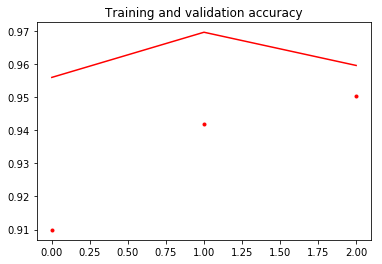

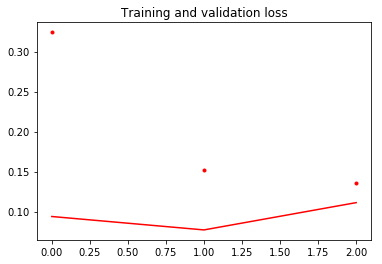

In [13]:
plot_training(history)

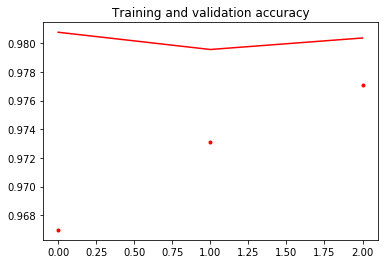

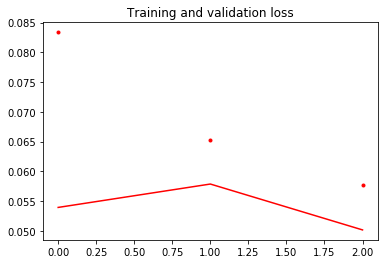

In [12]:
plot_training(history_ft)

In [23]:
#from IPython.display import Image
from PIL import Image as Image
from keras.preprocessing import image
from keras.models import load_model

def predict(img, target_size):
    if img.size != target_size:
        img = img.resize(target_size)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

def plot_preds(image, preds):
    plt.imshow(image)
    plt.axis('off')

    plt.figure()
    labels = ("cat", "dog")
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0,1.01)
    plt.tight_layout()
    plt.show()

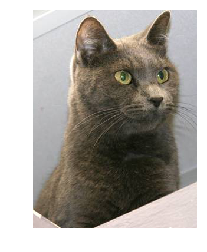

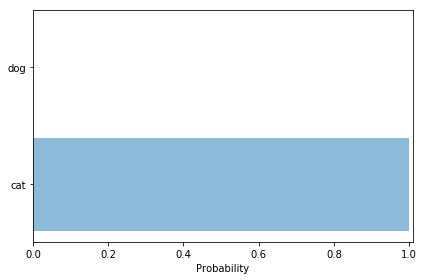

In [24]:
image_file = 'img1.jpg'
img = Image.open(image_file)
plot_preds(img, predict(img, (299, 299)))

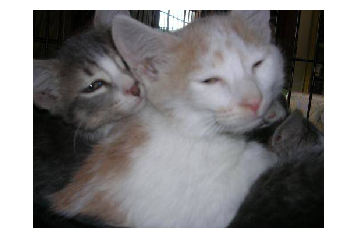

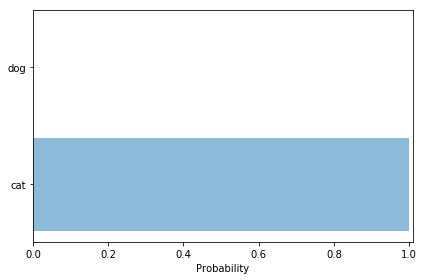

In [25]:
image_file = 'img2.jpg'
img = Image.open(image_file)
plot_preds(img, predict(img, (299, 299)))

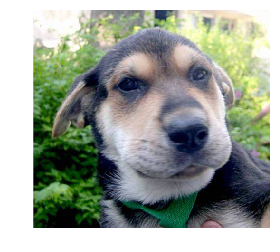

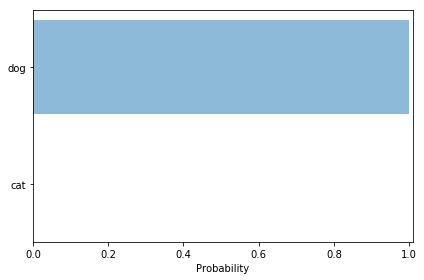

In [26]:
image_file = 'img3.jpg'
img = Image.open(image_file)
plot_preds(img, predict(img, (299, 299)))

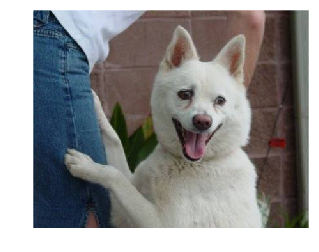

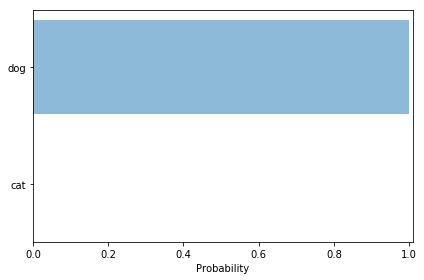

In [27]:
image_file = 'img4.jpg'
img = Image.open(image_file)
plot_preds(img, predict(img, (299, 299)))

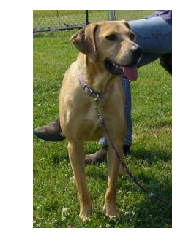

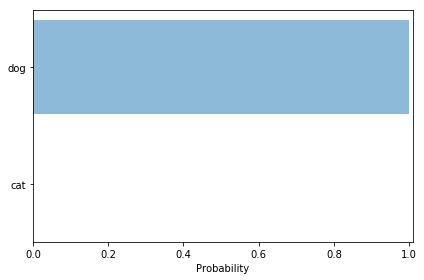

In [28]:
image_file = 'img5.jpg'
img = Image.open(image_file)
plot_preds(img, predict(img, (299, 299)))

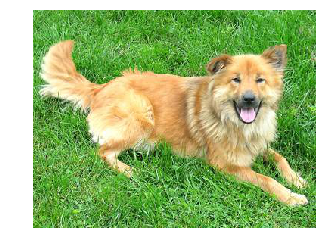

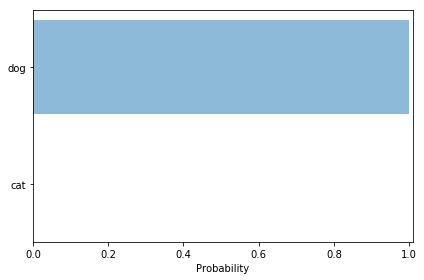

In [29]:
image_file = 'img6.jpg'
img = Image.open(image_file)
plot_preds(img, predict(img, (299, 299)))